# Imports

In [308]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Reshape, Lambda, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Data Loading and Preprocessing

In [309]:
bbox_df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
bbox_df.columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max']

In [188]:
bbox_df

image_name       x_min       y_min       x_max       y_max
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
..               ...         ...         ...         ...         ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196

[559 rows x 5 columns]

In [310]:
def load_and_preprocess_for_yolo(image_path, bbox, target_size=(416, 416)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    ih, iw = image.shape[:2]
    h, w = target_size
    
    # Resize image
    image = cv2.resize(image, target_size)
    
    # Normalize bounding box
    x_center = ((bbox['x_min'] + bbox['x_max']) / 2) / iw
    y_center = ((bbox['y_min'] + bbox['y_max']) / 2) / ih
    box_w = (bbox['x_max'] - bbox['x_min']) / iw
    box_h = (bbox['y_max'] - bbox['y_min']) / ih
    
    return image, np.array([x_center, y_center, box_w, box_h])


In [311]:
# Step 3: Splitting Dataset
image_dir = 'data/training_images/'
all_images = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# Filter dataframe for only the images we have
all_images = [image for image in all_images if bbox_df['image_name'].str.contains(os.path.basename(image)).any()]

bbox_df = bbox_df[bbox_df['image_name'].isin([os.path.basename(path) for path in all_images])]

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)


In [251]:
train_images

['data/training_images/vid_4_26560.jpg',
 'data/training_images/vid_4_14400.jpg',
 'data/training_images/vid_4_3360.jpg',
 'data/training_images/vid_4_26400.jpg',
 'data/training_images/vid_4_21300.jpg',
 'data/training_images/vid_4_880.jpg',
 'data/training_images/vid_4_16280.jpg',
 'data/training_images/vid_4_12240.jpg',
 'data/training_images/vid_4_9040.jpg',
 'data/training_images/vid_4_8280.jpg',
 'data/training_images/vid_4_14340.jpg',
 'data/training_images/vid_4_15020.jpg',
 'data/training_images/vid_4_26580.jpg',
 'data/training_images/vid_4_17040.jpg',
 'data/training_images/vid_4_12100.jpg',
 'data/training_images/vid_4_2020.jpg',
 'data/training_images/vid_4_29500.jpg',
 'data/training_images/vid_4_620.jpg',
 'data/training_images/vid_4_12300.jpg',
 'data/training_images/vid_4_16020.jpg',
 'data/training_images/vid_4_2400.jpg',
 'data/training_images/vid_4_17140.jpg',
 'data/training_images/vid_4_6300.jpg',
 'data/training_images/vid_4_12060.jpg',
 'data/training_images/vid

In [252]:
len(train_images), len(val_images)

(284, 71)

In [312]:
# Step 4: Data Generator
def data_generator(image_paths, bbox_df, batch_size=32):
    i = 0
    while True:
        batch_images = []
        batch_bboxes = []
        for _ in range(batch_size):
            if i == len(image_paths):
                i = 0
                np.random.shuffle(image_paths)
            image_path = image_paths[i]
            image_name = os.path.basename(image_path)
            bbox = bbox_df.loc[bbox_df['image_name'] == image_name].iloc[0]
            image, adjusted_bbox = load_and_preprocess_for_yolo(image_path, bbox)
            if image is not None:
                batch_images.append(image)
                batch_bboxes.append(adjusted_bbox)
            i += 1
        yield np.array(batch_images), np.array(batch_bboxes)


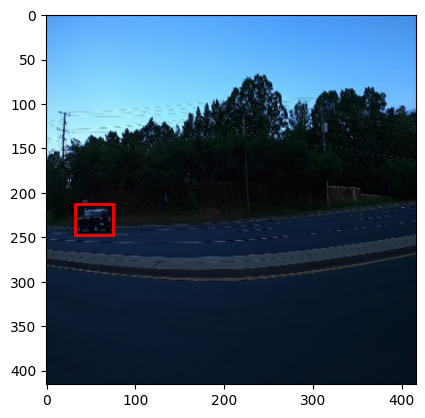

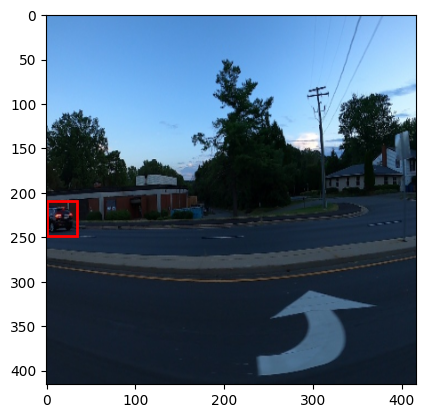

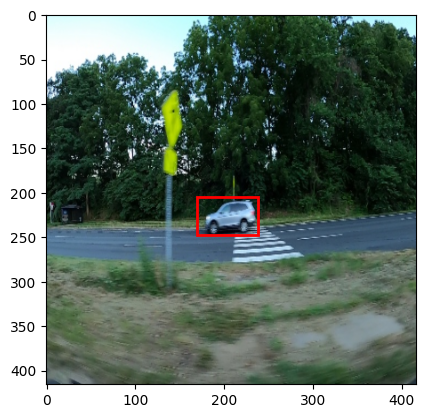

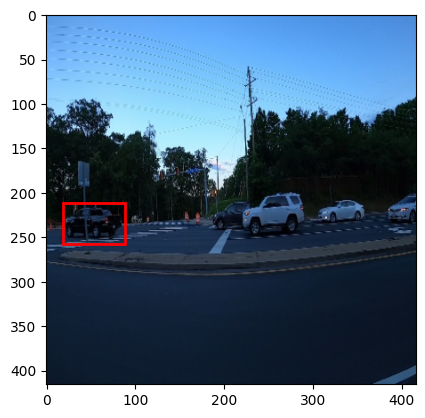

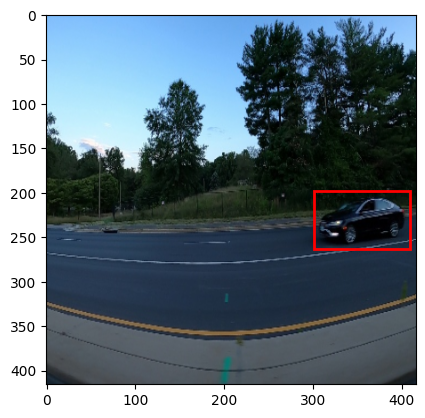

In [255]:
def convert_bbox_to_pixel(bbox, image_shape):
    ih, iw = image_shape[:2]
    x_center, y_center, box_w, box_h = bbox
    x_min = int((x_center - box_w / 2) * iw)
    y_min = int((y_center - box_h / 2) * ih)
    width = int(box_w * iw)
    height = int(box_h * ih)
    return [x_min, y_min, width, height]

# Function to plot a single image and bounding box
def plot_image_with_bbox(image, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

# Create a data generator for this small subset
test_gen = data_generator(train_images, bbox_df, batch_size=32)

# Load a batch of images and bounding boxes
batch_images, batch_bboxes = next(test_gen)

# Loop through the batch and plot each image with its bounding box
for i in range(5):
    image = batch_images[i]
    bbox = batch_bboxes[i]
    # Convert the normalized bounding box back to pixel coordinates
    pixel_bbox = convert_bbox_to_pixel(bbox, image.shape)
    # Plot the image with the bounding box
    plot_image_with_bbox(image, pixel_bbox)

In [280]:
train_gen = data_generator(train_images, bbox_df, batch_size=32)
val_gen = data_generator(val_images, bbox_df, batch_size=32)

In [313]:
def save_annotations_for_yolo(bbox_df, image_dir):
    for _, row in bbox_df.iterrows():
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        ih, iw = image.shape[:2]
        
        x_center = ((row['x_min'] + row['x_max']) / 2) / iw
        y_center = ((row['y_min'] + row['y_max']) / 2) / ih
        box_w = (row['x_max'] - row['x_min']) / iw
        box_h = (row['y_max'] - row['y_min']) / ih
        
        annotation_path = os.path.join(image_dir, os.path.splitext(image_name)[0] + '.txt')
        with open(annotation_path, 'w') as file:
            file.write(f"0 {x_center} {y_center} {box_w} {box_h}\n")  # Assuming class '0' for car

# Call this function for your training images directory
save_annotations_for_yolo(bbox_df, 'data/training_images')

In [318]:
data_yaml_content = {
    'train': 'training_images',
    'val': 'testing_images',
    'nc': 1,
    'names': ['car']
}

import yaml
with open('data/data.yaml', 'w') as file:
    yaml.dump(data_yaml_content, file, default_flow_style=False)

# Model

In [315]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")

In [316]:
# Define your custom configuration for training if needed
config = {
    'epochs': 50,  # Number of epochs to train for
    'batch_size': 16,  # Batch size
    'lr': 0.001,  # Learning rate
    # Add any other configuration parameters according to your needs
}

In [319]:
model.train(
    data='data/data.yaml',  # YAML file specifying dataset paths and classes
    imgsz=640,  # Image size
    batch=config['batch_size'],
    epochs=config['epochs'],
    lr0=config['lr'],  # Initial learning rate
)

Ultralytics YOLOv8.1.34 🚀 Python-3.12.0 torch-2.2.0 CPU (Intel Core(TM) i9-9880H 2.30GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

RuntimeError: Dataset 'data/data.yaml' error ❌ 
Dataset 'data/data.yaml' images not found ⚠️, missing path '/Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets/data/testing_images'
Note dataset download directory is '/Users/vladandreichuk/Desktop/git_reps/ComputerVision/datasets'. You can update this in '/Users/vladandreichuk/Library/Application Support/Ultralytics/settings.yaml'

In [240]:
from tensorflow.keras import layers, models

In [260]:
def create_model(input_shape=(416, 416, 3)):
    # Backbone: MobileNetV2 without the top layer, using pre-trained ImageNet weights
    backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Make the backbone not trainable
    backbone.trainable = False

    # Add additional convolutional layers to the backbone
    model = models.Sequential([
        backbone,
        layers.Conv2D(512, 3, 2, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
    ], name='backbone')

    # Regression head for bounding box predictions
    regression_head = models.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(4, activation = 'sigmoid'),  # Outputs 4 coordinates for the bounding box
    ], name='regression_head')

    # Combine the backbone and the regression head
    inputs = layers.Input(shape=input_shape)
    x = model(inputs)
    outputs = regression_head(x)

    final_model = models.Model(inputs=inputs, outputs=outputs, name='bbox_regressor')

    return final_model

# Model compilation
model = create_model()
model.compile(optimizer='adam', loss='mse')
model.summary()

/var/folders/sd/m36c35x53hb666q0qqt92wk40000gn/T/ipykernel_84416/3888643826.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "bbox_regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Sequential)           │ (None, 512)            │     8,156,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_head (Sequential)    │ (None, 4)              │       132,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,289,092 (31.62 MB)

 Trainable params: 6,031,108 (23.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def create_model(input_shape=(416, 416, 3)):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Use feature maps from the base model
    x = base_model.output

    # Custom layers on top of the base model
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Final layer for bounding box prediction
    x = Conv2D(4, (1, 1), activation='sigmoid', padding='same')(x)

    # Global Average Pooling to reduce spatial dimensions to 1x1 per feature map
    outputs = GlobalAveragePooling2D()(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Model compilation
model = create_model()
model.compile(optimizer='adam', loss='mse')
model.summary()

# Training

In [258]:
# Define training parameters
epochs = 10
batch_size = 32

In [282]:
# Fit the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images) // batch_size,
    epochs=epochs
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - loss: 0.0730 - val_loss: 0.1055
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - loss: 0.0309 - val_loss: 0.0846
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - loss: 0.0257 - val_loss: 0.0523
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - loss: 0.0292 - val_loss: 0.0753
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0244 - val_loss: 0.0406
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - loss: 0.0237 - val_loss: 0.0577
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0230 - val_loss: 0.0433
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0220 - val_loss: 0.0380
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0184 - val_loss: 0.0419
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0202 - val_loss: 0.0501


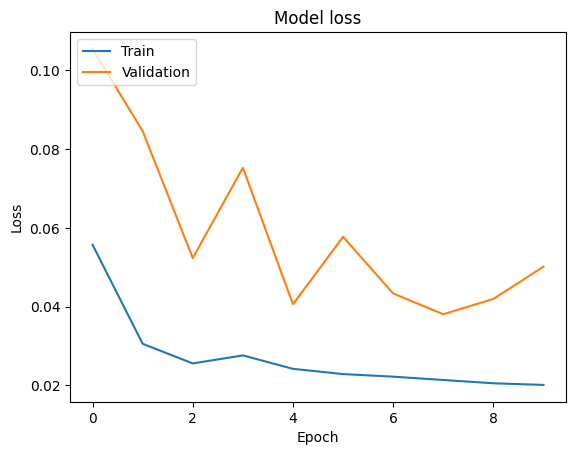

In [283]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

In [284]:
# Function to load and preprocess test images
def load_test_images(image_dir, target_size=(416, 416)):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg') or fname.endswith('.jpeg')]
    images = []
    resized_images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        images.append(image)
        image = cv2.resize(image, target_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
        resized_images.append(image)
    return image_paths, np.array(resized_images)


In [285]:
test_image_dir = 'data/testing_images/'
test_image_paths, test_images = load_test_images(test_image_dir)

In [291]:
test_images[0].shape

(416, 416, 3)

In [287]:
predicted_bboxes = model.predict(test_images)

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step


In [288]:
predicted_bboxes

array([[    0.64403,     0.73138,     0.18394,     0.21167],
       [    0.55629,     0.73769,     0.17937,     0.21052],
       [    0.68996,     0.73426,     0.18565,     0.21161],
       [    0.67415,      0.7369,     0.18252,     0.21092],
       [    0.64219,     0.73642,     0.18374,     0.21088],
       [    0.57759,     0.73634,     0.18104,     0.21042],
       [     0.6774,     0.73436,     0.18318,     0.21079],
       [    0.59712,     0.73227,     0.18285,     0.21038],
       [    0.69462,     0.73193,      0.1822,      0.2108],
       [    0.67083,     0.73201,     0.18264,     0.21131],
       [      0.631,     0.73306,     0.18339,     0.21125],
       [    0.63426,     0.73131,     0.18462,     0.21102],
       [    0.61041,     0.73523,     0.18108,     0.21019],
       [     0.6746,     0.73137,     0.18701,     0.21102],
       [    0.65471,     0.73571,     0.18259,     0.21081],
       [    0.61827,     0.73921,     0.18507,     0.21053],
       [    0.64189,    

In [220]:
# Convert predictions to original image size (utility function)
def convert_predictions_to_original_scale(predicted_bboxes, original_images):
    scaled_bboxes = []
    for i, bbox in enumerate(predicted_bboxes):
        ih, iw = original_images[i].shape[:2]
        x_center, y_center, box_w, box_h = bbox
        x_min = int((x_center - box_w / 2) * iw)
        y_min = int((y_center - box_h / 2) * ih)
        width = int(box_w * iw)
        height = int(box_h * ih)
        scaled_bboxes.append([x_min, y_min, width, height])
    return scaled_bboxes

In [297]:
# Scale predicted bounding boxes back to the original image size
#original_test_images = [cv2.imread(path) for path in test_image_paths]
scaled_bboxes = convert_predictions_to_original_scale(predicted_bboxes, test_images)


In [298]:
# Visualize predictions on test images
def visualize_prediction(image, pred_bbox, image_path=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.title(f"Prediction on Test Image")

    # Predicted bounding box
    rect_pred = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect_pred)
    if image_path:
        plt.savefig(f"predicted_pictures/predicted_{os.path.basename(image_path)}")
    plt.show()

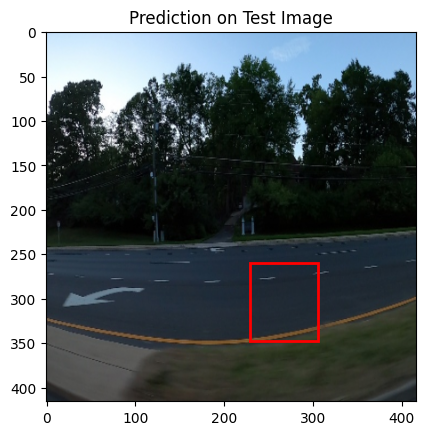

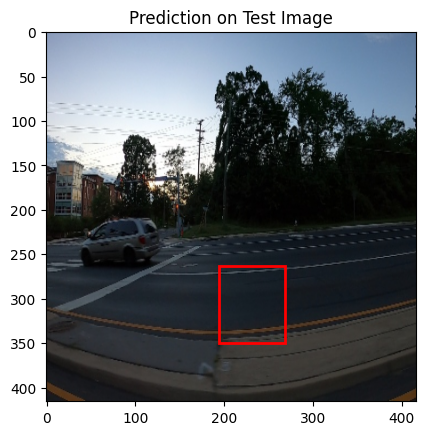

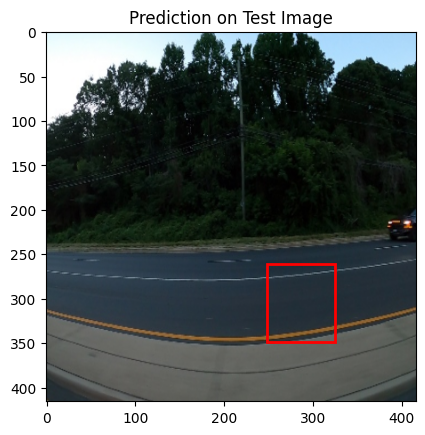

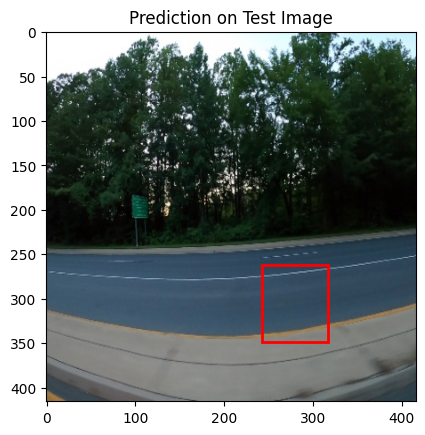

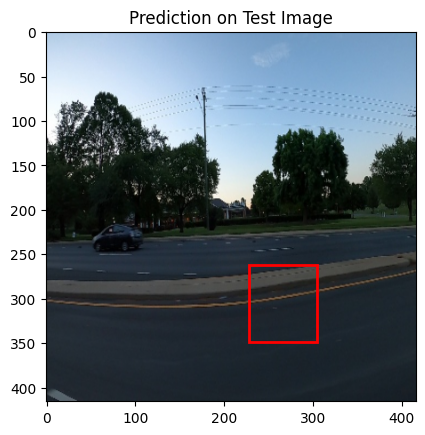

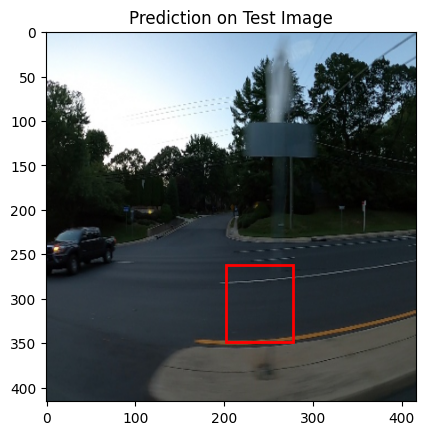

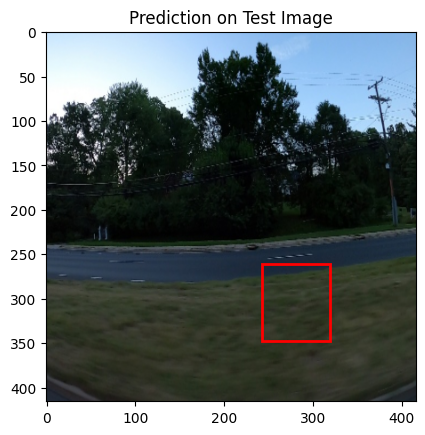

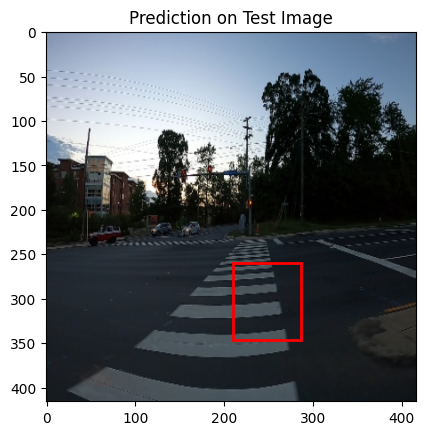

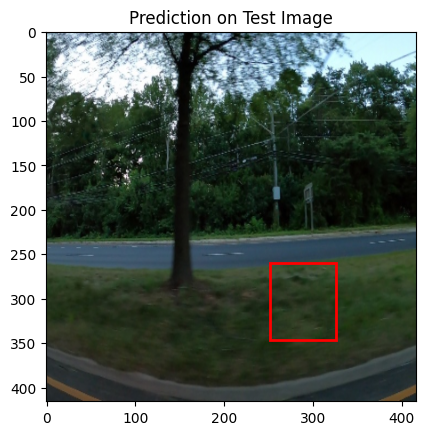

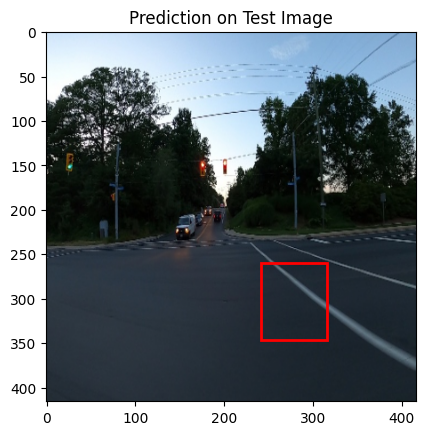

In [299]:
# Visualize a few test image predictions
for i in range(min(10, len(test_image_paths))):  # Visualize the first 5 predictions
    visualize_prediction(test_images[i], scaled_bboxes[i], test_image_paths[i])